In [3]:
import yaml
import torch
from models.sat_finetune import GraphTransformer,GraphDataset
from descriptor import MolTestDataset
import numpy as np
from torch_geometric.loader import DataLoader
import pandas as pd

def predict_pKa_csv(data_file,type):
    config_path = "config_finetune.yaml"

    if type=='acid':
        model_paths = [
            'model_weight/acid/model_1.pth',
            'model_weight/acid/model_2.pth',
            'model_weight/acid/model_3.pth',
            'model_weight/acid/model_4.pth',
            'model_weight/acid/model_5.pth'
        ]
        means = 5.7925
        stds = 2.3518

    elif type=='base':
        model_paths = [
            'model_weight/base/model_1.pth',
            'model_weight/base/model_2.pth',
            'model_weight/base/model_3.pth',
            'model_weight/base/model_4.pth',
            'model_weight/base/model_5.pth'
        ]
        means = 7.4623
        stds = 2.3085

    outputs = []

    for model_path in model_paths:
        config = yaml.load(open(config_path, "r", encoding="utf-8"), Loader=yaml.FullLoader)
        best_model = GraphTransformer(**config["sat"])
        test_dataset = GraphDataset(MolTestDataset(data_file, 'pKa'), degree=True, k_hop=3, se="khopgnn", use_subgraph_edge_attr=True)

        best_model.load_state_dict(torch.load(model_path))
        best_model.eval()
        test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
        test_pred = []
        with torch.no_grad():
            for data in test_loader:
                data.y = (data.y - means) / stds
                output = best_model(data)
                output = output * stds + means
                test_pred.extend(output.detach().cpu().numpy())

        outputs.append(test_pred)

    outputs = np.array(outputs)
    mean_outputs = np.mean(outputs, axis=0).flatten()
    std_outputs = np.std(outputs, axis=0).flatten()

    return mean_outputs, std_outputs




1.Acid

In [4]:

import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score,root_mean_squared_error


data_flie = 'data/test/novartis_acidic.csv'

pKa_data = pd.read_csv(data_flie)
pred_pKa,stds= predict_pKa_csv(data_flie,type='acid')
actual_pKa_values = pKa_data['pKa']

# Add predicted pKa and stds to the DataFrame
pKa_data['model'] = pred_pKa
pKa_data['std'] = stds

# Calculate metrics
actual_pKa_values = pKa_data['pKa']
mae = mean_absolute_error(actual_pKa_values, pred_pKa)
rmse = root_mean_squared_error(actual_pKa_values, pred_pKa)
r2 = r2_score(actual_pKa_values, pred_pKa)

# Print metrics
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)




MAE: 0.8371004458495549
RMSE: 1.0612155485914714
R2: 0.8268957094276705


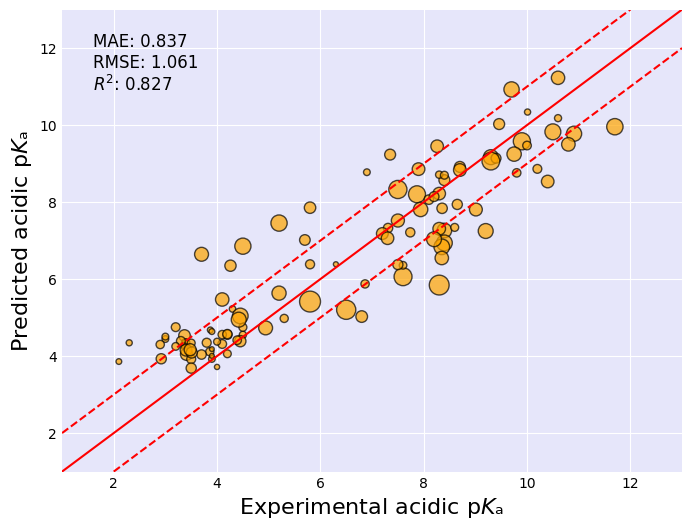

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(color='white')

# Scatter plot for acidic data
sc = ax.scatter(pKa_data['pKa'], pred_pKa, c='orange', alpha=0.7, s=stds*500, edgecolors='black')

ax.set_facecolor('lavender')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)

# Add title and labels
ax.set_xlabel('Experimental acidic p$K$ₐ', fontsize=16)
ax.set_ylabel('Predicted acidic p$K$ₐ', fontsize=16)

ax.text(0.05, 0.95, f"MAE: {mae:.3f}\nRMSE: {rmse:.3f}\n$R^2$: {r2:.3f}", fontsize=12, transform=ax.transAxes, verticalalignment='top')

ax.set_xlim(1, 13)
ax.set_ylim(1, 13)
ax.set_axisbelow(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))
ax.plot([1, 13], [1, 13], linestyle='-', color='red')
ax.plot([1, 12], [2, 13], linestyle='--', color='red')
ax.plot([2, 13], [1, 12], linestyle='--', color='red')

plt.show()


2.Base

In [6]:

import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score,root_mean_squared_error


data_flie = 'data/test/novartis_basic.csv'

pKa_data = pd.read_csv(data_flie)
pred_pKa,stds= predict_pKa_csv(data_flie,type='base')
actual_pKa_values = pKa_data['pKa']

mae = mean_absolute_error(actual_pKa_values, pred_pKa)
rmse = root_mean_squared_error(actual_pKa_values,pred_pKa)
r2 = r2_score(actual_pKa_values, pred_pKa)


print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)




MAE: 0.7128229754425232
RMSE: 0.904185128099273
R2: 0.8182040425250239


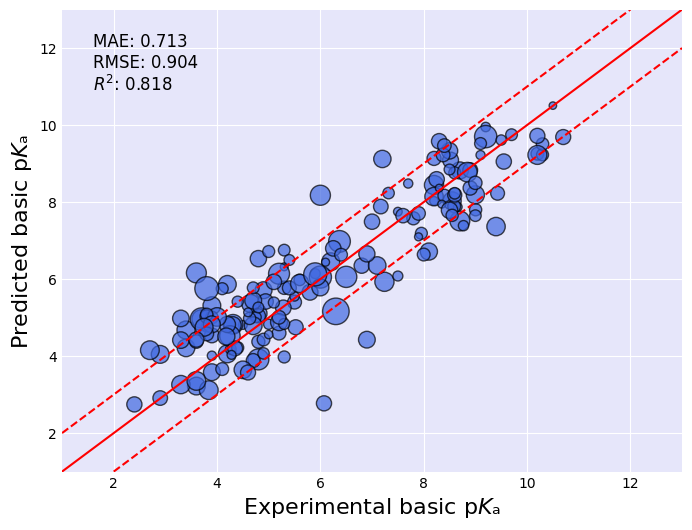

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(color='white')

# Scatter plot for acidic data
sc = ax.scatter(pKa_data['pKa'], pred_pKa, c='royalblue', alpha=0.7, s=stds*500, edgecolors='black')

ax.set_facecolor('lavender')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)

# Add title and labels
ax.set_xlabel('Experimental basic p$K$ₐ', fontsize=16)
ax.set_ylabel('Predicted basic p$K$ₐ', fontsize=16)

ax.text(0.05, 0.95, f"MAE: {mae:.3f}\nRMSE: {rmse:.3f}\n$R^2$: {r2:.3f}", fontsize=12, transform=ax.transAxes, verticalalignment='top')

ax.set_xlim(1, 13)
ax.set_ylim(1, 13)
ax.set_axisbelow(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))
ax.plot([1, 13], [1, 13], linestyle='-', color='red')
ax.plot([1, 12], [2, 13], linestyle='--', color='red')
ax.plot([2, 13], [1, 12], linestyle='--', color='red')

plt.show()
